#Analyzing Residential FAR Utilization in Atlanta
---
####This notebook documents the methodology used to analyze the ratio of real built square footage on each parcel versus the total allowed square footage allowed per parcel according to each parcel's lot size and zoning requirements. 

**Objective:**

To better understand whether zoning requirements are restricting the level of density per land area or if the market actually doesn't demand higher densities and more vertical development.

**Limits of analysis and assumptions:**
- Only analyzed residential parcels in the City of Atlanta
- ~19% of the parcels had a null value recorded for building square footage (BldgSF). This research excluded the null entries and did not analyze analyze vacant land and parcels with BldgSF recorded < 400 square feet
- ~23% of the parcels had a lot size in square feet (LotSize) recorded as zero. This research did not analyze parcels with a LotSize recorded < 400 square feet
- Excluded all parcels within SPI zones and all parcels with -C zoning


##0. Importing packages

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as pl
import numpy as np
%pylab inline
import statsmodels.api as sm1
import statsmodels.formula.api as sm
from shapely.geometry import Point, MultiPolygon

Populating the interactive namespace from numpy and matplotlib


------
##1. Importing data

####SCI Tax Data
- Description: http://www.atlantaga.gov/index.aspx?page=1070
- Direct download: http://ditweb.atlantaga.gov/sci/sci1.xlsx

In [2]:
# sci2013 = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/sci2013_hk.csv')
sci2013 = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/sci1.csv')
print sci2013.columns

Index([u'PARID', u'NPU', u'Neighborhood_Name', u'SCI_Landuse', u'Photographs',
       u'Lot_Condition', u'Structure_Condition', u'Sidewalks',
       u'Multiple_Violations', u'TMA', u'Market', u'County', u'SiteAddres',
       u'SiteCity', u'State', u'SiteZip', u'Subdivisio', u'LegalDesc',
       u'Legal1', u'Legal2', u'Legal3', u'Legal4', u'Lot', u'Block',
       u'Section_', u'Township', u'Range', u'MapGrid', u'MapPage', u'Bedrooms',
       u'Bathrooms', u'Stories', u'Units', u'Garages', u'LandUseGen',
       u'LandUseSpe', u'LotSize', u'BldgSF', u'YrBuilt', u'Owner_1',
       u'OwnerAdd', u'OwnerUnit', u'OwnerCity', u'OwnerZip', u'OwnerOcc',
       u'OwnerType', u'TaxYear_1', u'TaxVal', u'TranType', u'DocType',
       u'DistressFl', u'DistressDe', u'Seller', u'SellerType', u'Purchaser',
       u'PurchaserT', u'TranQtr', u'TranDate', u'ContractDa', u'FeedDate',
       u'TranVal', u'AVM', u'LoanValTot', u'Lender1', u'LoanVal1',
       u'LoanType1', u'IntRateTyp', u'Lender2', u'LoanVal2'

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (15,29,30,31,32,37,43,45,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print len(sci2013)
print len(sci2013[sci2013.LotSize == 0])
print len(sci2013[sci2013.BldgSF.isnull()])

160207
36751
29946


In [4]:
sci = sci2013[(sci2013.BldgSF.notnull()) & (sci2013.LotSize >= 400)]

sci.BldgSF = [float(entry) for entry in sci.BldgSF]

sci = sci[sci.BldgSF >= 400]

sci['built_far'] = sci.BldgSF/sci.LotSize

sci.YrBuilt = sci.YrBuilt.replace(' ', 0, regex=True)
sci.YrBuilt = [int(yr) for yr in sci.YrBuilt]
sci.YrBuilt = [float(yr) for yr in sci.YrBuilt]
# sci.YrBuilt = sci.YrBuilt.replace(0, np.nan, regex=True)

print len(sci)
print sci.columns.values

112250
['PARID' 'NPU' 'Neighborhood_Name' 'SCI_Landuse' 'Photographs'
 'Lot_Condition' 'Structure_Condition' 'Sidewalks' 'Multiple_Violations'
 'TMA' 'Market' 'County' 'SiteAddres' 'SiteCity' 'State' 'SiteZip'
 'Subdivisio' 'LegalDesc' 'Legal1' 'Legal2' 'Legal3' 'Legal4' 'Lot' 'Block'
 'Section_' 'Township' 'Range' 'MapGrid' 'MapPage' 'Bedrooms' 'Bathrooms'
 'Stories' 'Units' 'Garages' 'LandUseGen' 'LandUseSpe' 'LotSize' 'BldgSF'
 'YrBuilt' 'Owner_1' 'OwnerAdd' 'OwnerUnit' 'OwnerCity' 'OwnerZip'
 'OwnerOcc' 'OwnerType' 'TaxYear_1' 'TaxVal' 'TranType' 'DocType'
 'DistressFl' 'DistressDe' 'Seller' 'SellerType' 'Purchaser' 'PurchaserT'
 'TranQtr' 'TranDate' 'ContractDa' 'FeedDate' 'TranVal' 'AVM' 'LoanValTot'
 'Lender1' 'LoanVal1' 'LoanType1' 'IntRateTyp' 'Lender2' 'LoanVal2'
 'LoanType2' 'IntRateT_1' 'TitleCo' 'built_far']


//anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
# print len(set(sci.YrBuilt.values))
# print sorted(set(sci.YrBuilt.values))

In [6]:
checkfordups = pd.DataFrame(sci2013.PARID.groupby(sci2013['PARID']).count())
checkfordups.rename(columns = {0:'dup_counts'}, inplace=True)
checkfordups = checkfordups[checkfordups.dup_counts>1].sort('dup_counts')
print checkfordups.tail(20), '\n'
print len(checkfordups)

                   dup_counts
PARID                        
15 206 02 069               2
15 182 02 183               2
15 206 02 007               2
15 205 04 004               2
15 205 02 076               2
15 205 02 075               2
15 204 06 006               2
15 204 05 035               2
15 204 04 002               2
15 203 04 012               2
15 203 03 117               2
15 206 01 083               2
18 056 02 010               2
PROJECT NO M91522           3
15 240 04 040               3
18 056 01 036               3
15 242 01 062               4
15 211 04 169               5
                            5
15 211 04 173               6 

94


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


####Pre-joined (in QGIS) Zoning Base and Tax Parcel Shp Data
- Description: http://gis.atlantaga.gov/apps/gislayers/, 
- Parcels direct download: http://gis.atlantaga.gov/apps/gislayers/download/layers/COA_Parcels_2014.zip
- Zoning direct download: http://gis.atlantaga.gov/apps/gislayers/download/layers/ZoningBaseUpdated082014.zip
- Spatial join was performed using the centroids of the parcels

In [7]:
parcels_shp = gp.GeoDataFrame.from_file('/Users/hannahbkates/Desktop/Markets/Project/atl_shp/parcels_zoning.shp')
print parcels_shp.columns

Index([     u'ACRES',   u'ADDRESS1',   u'ADDRESS2',   u'ADDRESS3',
         u'ADDRESS5', u'ADDRPOSDIR', u'ADDRPREDIR', u'ADDRSTREET',
       u'ADDRSUFFIX', u'ADDRUNTTYP',    u'ADDUNIT',     u'ATLPIN',
           u'ATRPIN',     u'CASEIN',    u'CASEOUT',      u'CLASS',
           u'COUNTY', u'CREATEDATE',  u'CREATEDBY',     u'DIGEST',
           u'EXTVER', u'FUL_EX_COD', u'GIS_LAND_P',         u'ID',
       u'IMPRASSESS',  u'IMPR_APPR', u'LANDASSESS', u'LANDUSEGEN',
       u'LANDUSESPE', u'LANDUSE_DE',  u'LAND_APPR',  u'LIV_UNITS',
       u'LOT_CONDIT',        u'LUC',     u'MARKET', u'MULTIPLE_V',
             u'NBHD', u'NEIGHBORHO',        u'NPU',     u'OLD_ID',
            u'OWNER',    u'OWPART2',      u'PARID',      u'PCODE',
       u'PHOTOGRAPH',        u'PIN', u'PROP_CLASS', u'SCI_LANDUS',
       u'SHAPE_AREA', u'SHAPE_AR_2',  u'SHAPE_LEN', u'SHAPE_LE_2',
         u'SIDEWALK',   u'SITECITY',    u'SITEZIP',      u'SITUS',
              u'SPI',      u'STATE',     u'STATUS', u'STATUS_C

In [8]:
# print len(parcels_shp)

# prop_classes = pd.DataFrame(parcels_shp.PROP_CLASS.groupby(parcels_shp['PROP_CLASS']).count())
# print prop_classes

# prop_classes = pd.DataFrame(parcels_shp.SCI_LANDUS.groupby(parcels_shp['SCI_LANDUS']).count())
# print prop_classes

# prop_classes = pd.DataFrame(parcels_shp.LANDUSEGEN.groupby(parcels_shp['LANDUSEGEN']).count())
# print prop_classes

# prop_classes = pd.DataFrame(parcels_shp.LANDUSESPE.groupby(parcels_shp['LANDUSESPE']).count())
# print prop_classes

In [9]:
# checkfordups = pd.DataFrame(parcels_shp.PARID.groupby(parcels_shp['PARID']).count())
# checkfordups.rename(columns = {0:'dup_counts'}, inplace=True)
# checkfordups = checkfordups[checkfordups.dup_counts>1].sort('dup_counts')
# print checkfordups.tail(20), '\n'
# print len(checkfordups)

#### Creating list of all distinct ZONING designations assigned to the parcels

In [10]:
all_zones = sorted(set(parcels_shp.ZONING))
# print all_zones
all_zones = pd.DataFrame(all_zones)
all_zones.to_csv('/Users/hannahbkates/Desktop/Markets/Project/allzones.csv')

####Zoning Table Summary
- Contains restictions for residential zoning types
- Full zoning ordinance manual: https://www.municode.com/library/ga/atlanta/codes/code_of_ordinances?nodeId=PTIIICOORANDECO_PT16ZO

In [11]:
zoning = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/zoning_summary.csv')
print zoning

     zone  front  side  rear    lot  frontage  height  footprint    far  \
0     R-1     60    25    35  87120       200      35       0.25  0.250   
1     R-2     60    15    30  43560       150      35       0.35  0.300   
2    R-2A     60    15    30  30000       100      35       0.35  0.350   
3    R-2B     50    10    20  28000       100      35       0.40  0.400   
4     R-3     50    10    20  18000       100      35       0.40  0.400   
5    R-3A     50    10    15  13500        85      35       0.45  0.450   
6     R-4     35     7    15   9000        70      35       0.50  0.500   
7    R-4A     30     7    15   7500        50      35       0.55  0.500   
8    R-4B     20     5     5   2800        40      35       0.85  0.750   
9     R-5     30     7     7   7500        50      35       0.55  0.500   
10   RG-1     40   NaN   NaN   5000       NaN     NaN        NaN  0.162   
11   RG-2     40   NaN   NaN   5000       NaN     NaN        NaN  0.348   
12   RG-3     40   NaN   

----
##2. Joining datasets

####PARCELS: Joining SCI data with Tax Parcel shp file data on parcel ID (PARID)

####Testing match rate on PARID between datasets

In [12]:
sciPARIDs = pd.DataFrame(sorted(set(sci2013.PARID.values)))
print len(sciPARIDs), 'distinct PARIDs in the SCI dataset'
sciPARIDs.rename(columns={0:'PARID'}, inplace=True)
sciPARIDs['sci_PARID'] = sciPARIDs.PARID
# sciPARIDs.to_csv('/Users/hannahbkates/Desktop/Markets/Project/sciPARIDs.csv')

shpPARIDs = pd.DataFrame(sorted(set(parcels_shp.PARID.values)))
print len(shpPARIDs), 'distinct PARIDs in the shapefile dataset'
shpPARIDs.rename(columns={0:'PARID'}, inplace=True)
shpPARIDs['shp_PARID'] = shpPARIDs.PARID
# shpPARIDs.to_csv('/Users/hannahbkates/Desktop/Markets/Project/shpPARIDs.csv')

matching1 = pd.merge(shpPARIDs, sciPARIDs, how='outer', left_on='PARID', right_on='PARID')
matching2 = matching1[matching1.shp_PARID != matching1.sci_PARID]
print len(matching1), 'distinct PARIDs in the combined datasets'
print len(matching2), 'distinct PARIDs lack spatial/zoning data or tax appraisal data (only present in one dataset)'
print 100*float(len(matching2))/float(len(matching1)), '% of parcels lack spatial/zoning data or tax appraisal data (only present in one dataset)'
# matching2.to_csv('/Users/hannahbkates/Desktop/Markets/Project/unmatched.csv')

160098 distinct PARIDs in the SCI dataset
164559 distinct PARIDs in the shapefile dataset
165729 distinct PARIDs in the combined datasets
6801 distinct PARIDs lack spatial/zoning data or tax appraisal data (only present in one dataset)
4.103687345 % of parcels lack spatial/zoning data or tax appraisal data (only present in one dataset)


####4.1% of all distinct parcels did not have a match in both datasets

In [13]:
parcels = pd.merge(parcels_shp, sci, how = 'inner', left_on = 'PARID', right_on = 'PARID')
print len(parcels)
parcels.to_csv('/Users/hannahbkates/Desktop/Markets/Project/backup_allparcels_prekey.csv')

112869


In [14]:
parcels = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/backup_allparcels_prekey.csv')
parcels.rename(columns={0:'PARID'}, inplace=True)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7,18,19,40,57,65,76,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
print parcels.columns.values

['Unnamed: 0' 'ACRES' 'ADDRESS1' 'ADDRESS2' 'ADDRESS3' 'ADDRESS5'
 'ADDRPOSDIR' 'ADDRPREDIR' 'ADDRSTREET' 'ADDRSUFFIX' 'ADDRUNTTYP' 'ADDUNIT'
 'ATLPIN' 'ATRPIN' 'CASEIN' 'CASEOUT' 'CLASS' 'COUNTY' 'CREATEDATE'
 'CREATEDBY' 'DIGEST' 'EXTVER' 'FUL_EX_COD' 'GIS_LAND_P' 'ID' 'IMPRASSESS'
 'IMPR_APPR' 'LANDASSESS' 'LANDUSEGEN' 'LANDUSESPE' 'LANDUSE_DE'
 'LAND_APPR' 'LIV_UNITS' 'LOT_CONDIT' 'LUC' 'MARKET' 'MULTIPLE_V' 'NBHD'
 'NEIGHBORHO' 'NPU_x' 'OLD_ID' 'OWNER' 'OWPART2' 'PARID' 'PCODE'
 'PHOTOGRAPH' 'PIN' 'PROP_CLASS' 'SCI_LANDUS' 'SHAPE_AREA' 'SHAPE_AR_2'
 'SHAPE_LEN' 'SHAPE_LE_2' 'SIDEWALK' 'SITECITY' 'SITEZIP' 'SITUS' 'SPI'
 'STATE' 'STATUS' 'STATUS_COD' 'STRUCTURE_' 'STRUCT_FLR' 'STRUCT_YR'
 'STR_NUMBER' 'SUBAREA' 'SUBDIVISIO' 'SUNRISE' 'SUNSET' 'TAXPIN' 'TAXYEAR'
 'TAX_DISTR' 'TENURE' 'TIEBACK' 'TOT_APPR' 'TOT_ASSESS' 'TSA' 'UNIT_NUM'
 'VAL_ACRES' 'ZONE_simp' 'ZONING' 'geometry' 'NPU_y' 'Neighborhood_Name'
 'SCI_Landuse' 'Photographs' 'Lot_Condition' 'Structure_Condition'
 'Sidewalks

In [16]:
### There may be duplicates in the sci or shp data

In [17]:
checkfordups = pd.DataFrame(parcels.PARID.groupby(parcels['PARID']).count())
checkfordups.rename(columns = {0:'dup_counts'}, inplace=True)
checkfordups = checkfordups[checkfordups.dup_counts>1].sort('dup_counts')
checkfordups['exclude'] = 'exclude'
print checkfordups.tail(20)
print len(checkfordups)
# checkfordups.to_csv('/Users/hannahbkates/Desktop/Markets/Project/dupPARIDs.csv')

                 dup_counts  exclude
PARID                               
14 008400101618           2  exclude
14 008400101626           2  exclude
14 008400101634           2  exclude
14 008400101642           2  exclude
14 008400101659           2  exclude
14 008400101550           2  exclude
14 008400101444           2  exclude
14 008400111914           3  exclude
18 056 01 036             3  exclude
17 009600040237           3  exclude
17 024400030189           3  exclude
17 019000050298           3  exclude
17 006400090032           3  exclude
14F002500050597           3  exclude
17 004800020758           3  exclude
17 0045  LL0655           3  exclude
17 000900010731           4  exclude
14 000800080898           4  exclude
14 0110  LL0017           5  exclude
15 211 04 173             6  exclude
1009


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [18]:
# parcels = pd.merge(parcels, checkfordups, how='left', left_on='PARID', right_on='PARID')

######*(Manually created a key in excel to recode and simplify the zoning designations from allzones.csv)*
Created a flag to exclude parcels from analysis if they are part of an SPI or conditional zoning exception:
=IF(RIGHT(B2,2)="-C","C",IF(RIGHT(B2,5)="-C/BL","C",IF(LEFT(B2,3)="SPI","SPI","ok"))) where B2 is ZONING from allzones.csv

In [19]:
key = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/allzones_key.csv')
print key.head()

   Unnamed: 0 ZONING zkey flag
0           0    C-1  C-1   ok
1           1  C-1-C  C-1    C
2           2    C-2  C-2   ok
3           3  C-2-C  C-2    C
4           4    C-3  C-3   ok


####ZONING: Merging parcel data with zoning criteria using zoning key

In [20]:
parcels = pd.merge(parcels, key, how='left', left_on='ZONING', right_on='ZONING')
print len(parcels)

112869


In [21]:
parcels_z = pd.merge(parcels, zoning, how = 'inner', left_on = 'zkey', right_on = 'zone')
print parcels_z.columns
# print zoning_joined.head(20)
print len(parcels_z), len(parcels)

Index([u'Unnamed: 0_x', u'ACRES', u'ADDRESS1', u'ADDRESS2', u'ADDRESS3',
       u'ADDRESS5', u'ADDRPOSDIR', u'ADDRPREDIR', u'ADDRSTREET', u'ADDRSUFFIX',
       ...
       u'lot', u'frontage', u'height', u'footprint', u'far', u'far_cond',
       u'far_dup', u'sqft_max', u'min_min', u'parking'],
      dtype='object', length=171)
77935 112869


----
##4. Analyzing % FAR utilization versus tax appraisal value (tax $/built sq ft)

In [22]:
#need to remove non-residiential from R, R-G, and MR

i_analyze = (parcels_z.zkey<>'unknown')&(parcels_z.flag<>'SPI')&(parcels_z.flag<>'C')&(parcels_z.ZONING.notnull())
len(parcels_z[i_analyze]), len(parcels_z)
analyze = parcels_z[i_analyze]

In [23]:
tot = len(analyze)
freq = pd.DataFrame(analyze.ZONING.groupby(analyze.ZONING).count())
freq['per'] = 100*freq[0]/tot
# freq = freq.sort('per')
print freq

            0        per
ZONING                  
MR-2       41   0.057117
MR-3       96   0.133738
MR-4A      13   0.018110
MR-4B      14   0.019503
R-1       457   0.636650
R-2      1553   2.163495
R-2A      624   0.869299
R-2B      352   0.490374
R-3     11196  15.597225
R-3A      537   0.748098
R-3C       55   0.076621
R-4     31300  43.604246
R-4A     6588   9.177788
R-4B     1309   1.823577
R-5      5634   7.848764
RG-1        2   0.002786
RG-2     4480   6.241119
RG-3     4474   6.232760
RG-4     1840   2.563317
RG-5     1217   1.695411


In [24]:
simp = pd.concat([analyze.PARID, analyze.BldgSF, analyze.LotSize, analyze.built_far, 
                  analyze.zone, analyze.lot, analyze.height, analyze.footprint, 
                  analyze.far, analyze.far_cond, analyze.sqft_max, analyze.min_min 
                 ], axis=1)
print simp.head()

             PARID  BldgSF    LotSize  built_far zone   lot  height  \
0  17 004700020379    1517  15341.832   0.098880  R-4  9000      35   
1  17 004600040097    2096  24066.900   0.087091  R-4  9000      35   
2  17 004600020123    1608   8197.992   0.196146  R-4  9000      35   
3  17 004600030411    1196   7797.240   0.153388  R-4  9000      35   
4  17 004700040286    1502  11221.056   0.133855  R-4  9000      35   

   footprint  far  far_cond  sqft_max  min_min  
0        0.5  0.5       NaN       NaN      NaN  
1        0.5  0.5       NaN       NaN      NaN  
2        0.5  0.5       NaN       NaN      NaN  
3        0.5  0.5       NaN       NaN      NaN  
4        0.5  0.5       NaN       NaN      NaN  


In [25]:
simp['check_lot'] = (simp.lot <= simp.LotSize)
simp['check_far'] = np.nan
simp['final_sqftmax'] = np.nan
simp['utilized'] = np.nan

# print simp.tail(100)

In [59]:
def calc_utilization(df):
    for i, row in df.iterrows():
        if ((row['check_lot'] == False) & (row['far_cond'] > 0)): ## checking for lot < the min lot size and conditional far
            alt1 = row['LotSize']*row['far_cond'] ## using conditional FAR for lots smaller than min lot size
            alt2 = row['sqft_max'] ## using conditional max sqft for lots smaller than min lot size 
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far_cond'])
        else:
            alt1 = row['LotSize']*row['far'] #limited by max far
            if row['footprint'] > 0:
                alt2 = row['LotSize']*row['footprint']*(row['height']//12) #limited by max footprint and max height
            else:
                alt2 = 666666666666666
            alts = [alt1, alt2]
            df.loc[i, 'final_sqftmax'] = min(alts)
            df.loc[i, 'utilized'] = float(row['BldgSF'])/min(alts)
            df.loc[i, 'check_far'] = (row['built_far'] <= row['far'])
            
calc_utilization(simp)

In [60]:
min(simp.utilized), max(simp.utilized)

(0.00049340076477118536, 12.70128884408583)

In [61]:
simp.to_csv('/Users/hannahbkates/Desktop/Markets/Project/utilization.csv')

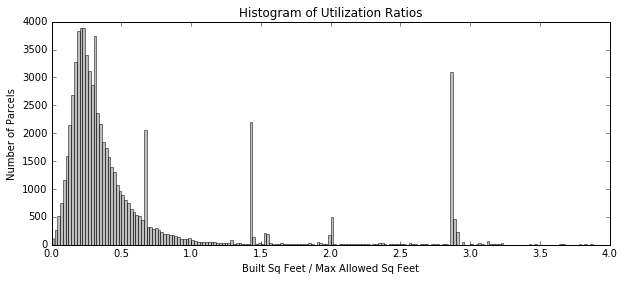

0.312702256547


In [62]:
fig2 = plt.figure(figsize=(10,4))
ax2 = fig2.add_subplot(111)

nbins = 200
ax2.hist(simp.utilized[simp.utilized < 4].values, nbins, color='grey', alpha=.5)
pl.title('Histogram of Utilization Ratios')
pl.xlabel('Built Sq Feet / Max Allowed Sq Feet')
pl.ylabel('Number of Parcels')
plt.show()

print median(simp.utilized[(simp.final_sqftmax != 66666)&(simp.utilized<8)])

In [63]:
print 'total # of parcels analyzed: ', len(simp)
print '# of parcels with util. ratio > 1: ', len(simp.utilized[simp.utilized > 1])
print '% of parcels with util. ratio > 1: ', 100*len(simp.utilized[simp.utilized > 1])/len(simp.utilized), '%'
print '% of parcels with util. ratio < 1: ', 100-100*len(simp.utilized[simp.utilized > 1])/len(simp.utilized), '%\n'

total # of parcels analyzed:  71782
# of parcels with util. ratio > 1:  9755
% of parcels with util. ratio > 1:  13 %
% of parcels with util. ratio < 1:  87 %



In [71]:
simp1 = pd.merge(simp, parcels_z, how='left', left_on='PARID', right_on='PARID')
i_condo = simp1.LANDUSE_DE.str.contains('CONDOMINIUM')
i_notcondo = [not i for i in i_condo]
simp1 = simp1[i_notcondo]
print simp1.head()
print simp1.columns.values

             PARID  BldgSF_x  LotSize_x  built_far_x zone_x  lot_x  height_x  \
0  17 004700020379      1517  15341.832     0.098880    R-4   9000        35   
1  17 004600040097      2096  24066.900     0.087091    R-4   9000        35   
2  17 004600020123      1608   8197.992     0.196146    R-4   9000        35   
3  17 004600030411      1196   7797.240     0.153388    R-4   9000        35   
4  17 004700040286      1502  11221.056     0.133855    R-4   9000        35   

   footprint_x  far_x  far_cond_x   ...    lot_y  frontage height_y  \
0          0.5    0.5         NaN   ...     9000        70       35   
1          0.5    0.5         NaN   ...     9000        70       35   
2          0.5    0.5         NaN   ...     9000        70       35   
3          0.5    0.5         NaN   ...     9000        70       35   
4          0.5    0.5         NaN   ...     9000        70       35   

  footprint_y  far_y  far_cond_y  far_dup  sqft_max_y min_min_y parking  
0         0.5    0

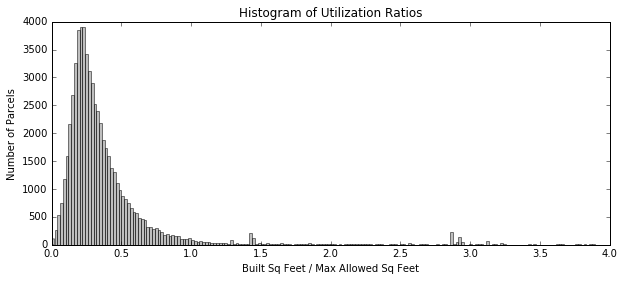

In [91]:
fig2 = plt.figure(figsize=(10,4))
ax2 = fig2.add_subplot(111)

nbins = 200
ax2.hist(simp1.utilized[simp1.utilized < 4].values, nbins, color='grey', alpha=.5)
pl.title('Histogram of Utilization Ratios')
pl.xlabel('Built Sq Feet / Max Allowed Sq Feet')
pl.ylabel('Number of Parcels')
plt.show()

In [72]:
plot1 = pd.concat([simp1.zkey, simp1.LAND_APPR, simp1.LotSize_y, simp1.utilized, simp1.YrBuilt], axis=1)
plot1['valsqft'] = plot1.LAND_APPR/plot1.LotSize_y
                         
print plot1.head()

  zkey  LAND_APPR  LotSize_y  utilized  YrBuilt    valsqft
0  R-4     118300  15341.832  0.197760     1947   7.710944
1  R-4     142700  24066.900  0.174181     1930   5.929305
2  R-4      98400   8197.992  0.392291     1935  12.002939
3  R-4      97300   7797.240  0.306775     1930  12.478775
4  R-4     106800  11221.056  0.267711     1948   9.517821


#####Linear Regression -- OLS

In [78]:
set1 = pd.concat([plot1.valsqft, plot1.utilized], axis=1)
set1.rename(columns={'valsqft':'x', 'utilized':'y'}, inplace=True)
set1 = set1.sort('x')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [79]:
ols1_value = sm.ols(formula='y ~ x + I((x))', data=set1, missing='drop').fit()

print 'Land Value 1st DEGREE--\n\nParameters:\n', ols1_value.params, '\n'
print 'R-squared:\n', ols1_value.rsquared, '\n'

# print (ols1_value.summary())

ols2_value = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', data=set1, missing='drop').fit()

print 'Land Value 2nd DEGREE--\n\nParameters:\n', ols2_value.params, '\n'
print 'R-squared:\n', ols2_value.rsquared, '\n'

# print (ols2_value.summary())

ols3_value = sm.ols(formula='y ~ x + I((x)) + I ((x)**2) + I ((x)**3)', data=set1, missing='drop').fit()

print 'Land Value 3rd DEGREE--\n\nParameters:\n', ols2_value.params, '\n'
print 'R-squared:\n', ols2_value.rsquared, '\n'

# print (ols3_value.summary())

Land Value 1st DEGREE--

Parameters:
Intercept    0.25166
x            0.01262
I((x))       0.01262
dtype: float64 

R-squared:
0.233194188276 

Land Value 2nd DEGREE--

Parameters:
Intercept      0.216688
x              0.016456
I((x))         0.016456
I((x) ** 2)   -0.000102
dtype: float64 

R-squared:
0.24974262395 

Land Value 3rd DEGREE--

Parameters:
Intercept      0.216688
x              0.016456
I((x))         0.016456
I((x) ** 2)   -0.000102
dtype: float64 

R-squared:
0.24974262395 



In [35]:
# print mean(df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values-1890)
# print std(df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values-1890)
# print len(df)
# print min(df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values)
# print (df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values-1890)/max(df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values-1890)

#####Plotting data with best fit lines

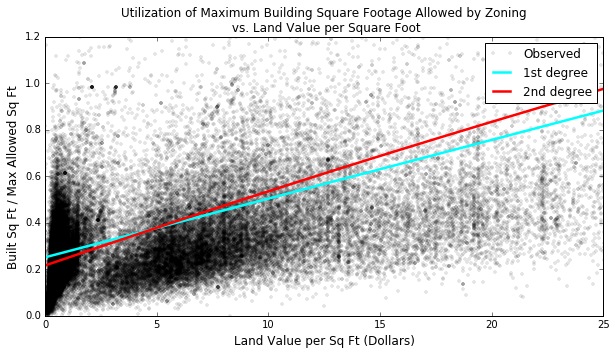

In [90]:
pl.figure(figsize=(10,5))

# pl.plot(plot1.valsqft[(~plot1.zkey.str.startswith('RG-'))&(~plot1.zkey.str.startswith('MR-'))], 
#         plot1.utilized[(~plot1.zkey.str.startswith('RG-'))&(~plot1.zkey.str.startswith('MR-'))], 
#         '.', color='black', alpha=.1, label='Observed')
pl.plot(plot1.valsqft, plot1.utilized, 
        '.', alpha=.1, label='Observed', color='black')

pl.plot(set1.x, ols1_value.predict(), label='1st degree', lw=2.5, color='cyan')
pl.plot(set1.x, ols2_value.predict(), label='2nd degree', lw=2.5, color='red')

pl.xlim(0,25)
pl.xlabel('Land Value per Sq Ft (Dollars)', fontsize = 12)
pl.ylim(0,1.2)
pl.ylabel('Built Sq Ft / Max Allowed Sq Ft', fontsize = 12)
pl.title('Utilization of Maximum Building Square Footage Allowed by Zoning\n vs. Land Value per Square Foot')
pl.legend()

In [37]:
# pl.figure(figsize=(15,5))

# pl.subplot(1,2,1)
# pl.plot(far.x, far.y, '.', color='grey', alpha=0.3, label='Observed')
# # pl.plot(far.x, ols1_far_all.predict(), label='1st degree')
# # pl.plot(far.x, ols2_far_all.predict(), label='2nd degree')
# pl.ylim(0,10)
# # pl.xscale('log')
# pl.xlim(0,200)
# pl.grid(True, which='both')
# pl.title('All Parcels with Max FAR Restriction\n')
# pl.ylabel('Built FAR / Max FAR')
# pl.xlabel('Land Value per Sq Ft')
# pl.legend()

# mycolor = (df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values-1890)/max(df.sci_YrBuil[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)].values-1890)
# pl.subplot(1,2,2)
# pl.scatter(np.log10(far.x[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)]),
#            far.y[(~np.isnan(df.sci_YrBuil)) & (far.y>0) * (far.y <= 2)],
#            c=mycolor, alpha=0.5,
#            marker='+', cmap=pl.cm.gnuplot, label='Observed')
# # pl.plot(far.x[far.y <= 1], ols1_far_within.predict(), label='1st degree'))
# # pl.plot(far.x[far.y <= 1], ols2_far_within.predict(), label='2nd degree')
# # pl.xscale('log')
# pl.grid(True, which='both')
# pl.ylim(0,1.5)
# # pl.xlim(0,200)
# pl.colorbar()
# pl.title('Parcels with Max FAR Restriction & FAR Utilization <= 100%\n')
# pl.ylabel('Built FAR / Max FAR')
# pl.xlabel('Land Value per Sq Ft (Log Scale)')
# pl.legend()

#####Examining Data by Year Built

In [38]:
# print plot1.YrBuilt.groupby(plot1.YrBuilt).count()

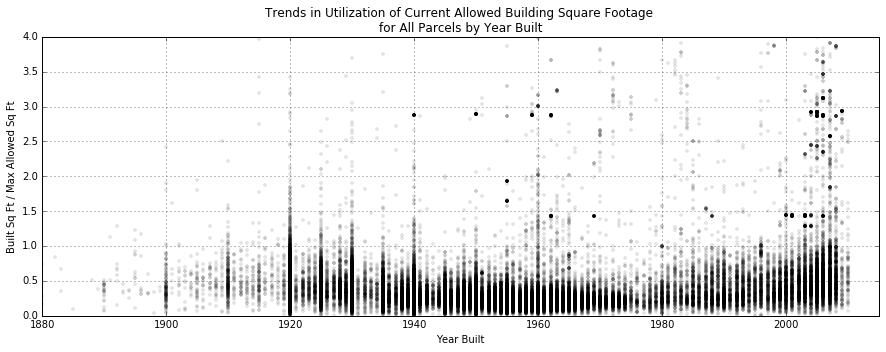

In [84]:
pl.figure(figsize=(15,5))

pl.plot(plot1.YrBuilt[plot1.YrBuilt>0], plot1.utilized[plot1.YrBuilt>0], '.', color='black', alpha=0.1)
pl.ylim(0,4)
pl.xlim(1880,2015)
pl.title('Trends in Utilization of Current Allowed Building Square Footage \nfor All Parcels by Year Built')
pl.ylabel('Built Sq Ft / Max Allowed Sq Ft')
pl.xlabel('Year Built')
pl.grid()
# pl.legend()

#####Log-likelihood ratio to test models

In [86]:
lr =  -2*(ols1_value.llf-ols2_value.llf )
print ("1 --> 2 lr = ", lr)

lr =  -2*(ols2_value.llf-ols3_value.llf )
print ("2 --> 3 lr = ", lr)

('1 --> 2 lr = ', 1366.0231976520154)
('2 --> 3 lr = ', 6.6885683531145332)


#####All ratios are greater than the critical value of 3.84 (for alpha of 0.05)

---
##5. Analyzing % FAR utilization versus distance from MARTA rail stations

In [ ]:
prox_marta = pd.read_csv('/Users/hannahbkates/Desktop/Markets/Project/atl_shp/proximity_marta.csv')
print prox_marta.columns

In [ ]:
prox_marta = pd.merge(prox_marta, far, how='outer', left_on='InputID', right_on='PARID')
prox_marta.rename(columns = {'y': 'per_far', 'x': 'dolsf_far'}, inplace=True)
prox_marta = pd.merge(prox_marta, lot, how='outer', left_on='InputID', right_on='PARID')
prox_marta.rename(columns = {'y': 'per_lot', 'x': 'dolsf_lot'}, inplace=True)
print prox_marta.columns

In [ ]:
print prox_marta.head()

#####First degree polynomial line OLS

In [ ]:
prox_marta = prox_marta.sort('Distance')

print len(prox_marta)

# np.std(prox_marta)

In [ ]:
marta_far = pd.concat([prox_marta.Distance[~np.isnan(prox_marta.per_far)], 
                       prox_marta.per_far[~np.isnan(prox_marta.per_far)]], axis=True)

marta_far.rename(columns={'Distance':'x', 'per_far':'y'}, inplace=True)
print marta_far.tail()
print len(marta_far)

In [ ]:
marta_lot = pd.concat([prox_marta.Distance[~np.isnan(prox_marta.per_lot)], 
                       prox_marta.per_lot[~np.isnan(prox_marta.per_lot)]], axis=True)

marta_lot.rename(columns={'Distance':'x', 'per_lot':'y'}, inplace=True)
print marta_lot.tail()
print len(marta_lot)

In [ ]:
marta1_far_all = sm.ols(formula='y ~ x + I((x))', data=marta_far, missing='drop').fit()

print 'FAR ALL 1st DEGREE--\n\nParameters:\n', marta1_far_all.params, '\n'
print 'R-squared:\n', marta1_far_all.rsquared, '\n'

marta1_far_within = sm.ols(formula='y ~ x + I((x))', data=marta_far[marta_far.y <= 1], missing='drop').fit()

print 'FAR <=100% 1st DEGREE--\n\nParameters:\n', marta1_far_within.params, '\n'
print 'R-squared:\n', marta1_far_within.rsquared

# print (ols1_far_all.summary())
# print (ols1_far_within.summary())

In [ ]:
marta1_lot_all = sm.ols(formula='y ~ x + I((x))', data=marta_lot, missing='drop').fit()

print 'LOT ALL 1st DEGREE--\n\nParameters:\n', marta1_lot_all.params, '\n'
print 'R-squared:\n', marta1_lot_all.rsquared, '\n'

marta1_lot_within = sm.ols(formula='y ~ x + I((x))', data=marta_lot[marta_lot.y >= 1], missing='drop').fit()

print 'LOT >=100% 1st DEGREE--\n\nParameters:\n', marta1_lot_within.params, '\n'
print 'R-squared:\n', marta1_lot_within.rsquared

# print (ols1_far_all.summary())
# print (ols1_far_within.summary())

#####Second degree polynomial line OLS

In [ ]:
marta2_far_all = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', 
                        data=marta_far, missing='drop').fit()

print 'FAR ALL 2nd DEGREE--\n\nParameters:\n', marta2_far_all.params, '\n'
print 'R-squared:\n', marta2_far_all.rsquared, '\n'

marta2_far_within = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', 
                           data=marta_far[marta_far.y <= 1], missing='drop').fit()

print 'FAR <=100% 2nd DEGREE--\n\nParameters:\n', marta2_far_within.params, '\n'
print 'R-squared:\n', marta2_far_within.rsquared

# print (ols2_far_all.summary())
# print (ols2_far_within.summary())

In [ ]:
marta2_lot_all = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', 
                        data=marta_lot, missing='drop').fit()

print 'LOT ALL 2nd DEGREE--\n\nParameters:\n', marta2_lot_all.params, '\n'
print 'R-squared:\n', marta2_lot_all.rsquared, '\n'

marta2_lot_within = sm.ols(formula='y ~ x + I((x)) + I ((x)**2)', 
                           data=marta_lot[marta_lot.y >= 1], missing='drop').fit()

print 'LOT >=100% 2nd DEGREE--\n\nParameters:\n', marta2_lot_within.params, '\n'
print 'R-squared:\n', marta2_lot_within.rsquared

# print (ols1_far_all.summary())
# print (ols1_far_within.summary())

In [ ]:
pl.figure(figsize=(15,12))

pl.subplot(2,2,1)
pl.plot(marta_far.x, marta_far.y, '.', color='grey', alpha=0.3)
pl.plot(marta_far.x, marta1_far_all.predict(), label='1st degree', linewidth=2.0)
pl.plot(marta_far.x, marta2_far_all.predict(), label='2nd degree', linewidth=2.0)
pl.ylim(0,5)
pl.xlim(0,40000)
pl.title('All Parcels with Max FAR Restriction')
pl.ylabel('Built FAR / Max FAR')
pl.xlabel('Distance from MARTA')
pl.legend()

pl.subplot(2,2,2)
pl.plot(marta_far.x[marta_far.y <= 1], marta_far.y[marta_far.y <= 1], '.', color='grey', alpha=0.3)
pl.plot(marta_far.x[marta_far.y <= 1], marta1_far_within.predict(), label='1st degree', linewidth=2.0)
pl.plot(marta_far.x[marta_far.y <= 1], marta2_far_within.predict(), label='2nd degree', linewidth=2.0)
pl.ylim(0,1)
pl.xlim(0,40000)
pl.title('All Parcels with Max FAR Restriction & FAR <= 100%')
pl.ylabel('Built FAR / Max FAR')
pl.xlabel('Distance from MARTA')
pl.legend()

pl.subplot(2,2,3)
pl.plot(np.log10(marta_lot.x), marta_lot.y, '.', color='#488AC7', alpha=0.3)
# pl.plot(marta_lot.x, marta1_lot_all.predict(), label='1st degree', linewidth=2.0)
# pl.plot(marta_lot.x, marta2_lot_all.predict(), label='2nd degree', linewidth=2.0)
pl.ylim(0,5)
# pl.xlim(0,40000)
pl.title('All Parcels with Min Lot Size Restriction')
pl.ylabel('Lot Size / Min Lot Size')
pl.xlabel('Log10 (Distance from MARTA)')
pl.legend()

pl.subplot(2,2,4)
pl.plot(marta_lot.x[marta_lot.y >= 1], marta_lot.y[marta_lot.y >= 1], '.', color='#488AC7', alpha=0.2)
pl.plot(marta_lot.x[marta_lot.y >= 1], marta1_lot_within.predict(), label='1st degree', linewidth=2.0)
pl.plot(marta_lot.x[marta_lot.y >= 1], marta2_lot_within.predict(), label='2nd degree', linewidth=2.0)
pl.ylim(1,5)
pl.xlim(0,40000)
pl.title('Parcels with Min Lot Size Restriction & Lot Sizes >= 100%')
pl.ylabel('Lot Size / Min Lot Size')
pl.xlabel('Distance from MARTA')
pl.legend()

#####Log-likelihood ratio to test models

In [ ]:
lr =  -2*(marta1_far_all.llf-marta2_far_all.llf )
print ("far_all lr = ", lr)

lr =  -2*(marta1_far_within.llf-marta2_far_within.llf )
print ("far_within lr = ", lr)

lr =  -2*(marta1_lot_all.llf-marta2_lot_all.llf )
print ("lot_all lr = ", lr)

lr =  -2*(marta1_lot_within.llf-marta2_lot_within.llf )
print ("lot_within lr = ", lr)

#####All ratios are greater than the critical value of 3.84 (for alpha of 0.05)

----
##6. Analyzing % FAR utilization versus distance from Beltline